# Single Perceptron Reinforcement Learning-Based Parameter Estimation

__Goal__: Test the ability for our single perceptron model to perform on more general problems:
 - Higher dimensionality data.
 - Nonlinearly separable data.
 - __Classification__ tasks (stick a sigmoid function on the end).
 - Larger and smaller memory buffers (especially in contrast to data dimensionality).


## Findings

 - Despite N_HIST = 2, it was able to converge well for DIM = 10+ !!
     - Likely in part thanks to stochastic policy.
 - Logistic regression also converges well! Would be a good idea to perform some sort of regularization in the future.
 - Likely ready to start doing some MLP tests, will do additional single-unit tests using Julia scripts/cmd args.

## Resulting Ideas

 - Definitely would be cool to experiment with a recurrent neural network-based policy.
     - Could take advantage of advances in GRU's and Transformers.
 - Definitely would be cool to play around with local informational backpropagation. 
 - Easiest way to completely automate experiments would be with callable Julia script + command line args.


In [1]:
# IMPORT BOX #
using LinearAlgebra
using Plots
using Plotly
using Random
using StatsFuns

import JSON

# plotly(size=(500,500))

HTML{String}("<script>\n// Immediately-invoked-function-expression to avoid global variables.\n(function() {\n    var warning_div = document.getElementById(\"webio-warning-8803218068486167822\");\n    var hide = function () {\n        var script = document.getElementById(\"webio-setup-4177893199594663719\");\n        var parent = script && script.parentElement;\n        var grandparent = parent && parent.parentElement;\n        if (grandparent) {\n            grandparent.style.display = \"none\";\n        }\n        warning_div.style.display = \"none\";\n    };\n    if (typeof Jupyter !== \"undefined\") {\n        console.log(\"WebIO detected Jupyter notebook environment.\");\n        // Jupyter notebook.\n        var extensions = (\n            Jupyter\n            && Jupyter.notebook.config.data\n            && Jupyter.notebook.config.data.load_extensions\n        );\n        if (extensions && extensions[\"webio-jupyter-notebook\"]) {\n            // Extension already loaded.\n            console.log(\"Jupyter WebIO nbextension detected; not loading ad-hoc.\");\n            hide();\n            return;\n        }\n    } else if (window.location.pathname.includes(\"/lab\")) {\n        // Guessing JupyterLa\n        console.log(\"Jupyter Lab detected; make sure the @webio/jupyter-lab-provider labextension is installed.\");\n        hide();\n        return;\n    }\n})();\n\n</script>\n<p\n    id=\"webio-warning-8803218068486167822\"\n    class=\"output_text output_stderr\"\n    style=\"padding: 1em; font-weight: bold;\"\n>\n    Unable to load WebIO. Please make sure WebIO works for your Jupyter client.\n    For troubleshooting, please see <a href=\"https://juliagizmos.github.io/WebIO.jl/latest/providers/ijulia/\">\n    the WebIO/IJulia documentation</a>.\n    <!-- TODO: link to installation docs. -->\n</p>\n")

In [12]:
# CONSTANTS #
DIM = 10 # Dimensionality of weight vector (data has d-1 dimensions)
W_RANGE = 10 # Range for the target vector (~uniform(+/-))
X_RANGE = 20 # Range for values in training data (~uniform(+/-))
N = 200 # Number of datapoints in a given batch of generated data.
N_HIST = 2 # Number of `action` and `rewards` in the history buffer.
# ϵ = 0.1 # Weight update rate
ϵ = 0.01
α = 0.1 # Q-learning rate
γ = 0.8 # Future reward discount factor

0.8

In [13]:
# Including Library Functions #
include("RLPerceptron.jl")

loss_logistic (generic function with 1 method)

## Caching Functions
 - [x] Implement caching system for results $\to$ `/results/final/linear_10_adaptive.json`.
 - [ ] Implement caching system for results $\to$ `/results/final/linear_10_applied.json`.
 - [x] Implement caching system for results $\to$ `/results/final/logistic_2_adaptive.json`.
 - [x] Implement caching system for results $\to$ `/results/final/logistic_2_applied.json`.

In [21]:
function cache_02(destination; losses, target_perceptron, generated_perceptron, policy, 
                  datapoints, train_policy, alpha, epsilon, gamma, dim, explore_prob)
    """
    Function to cache `loss[]`, `target perceptron`, `generated perceptron`, 
    `generated_policy`, `x`, `train_policy`.
    """
    
    output_dict = Dict{String, Any}(
        "losses" => losses,
        "target_perceptron" => target_perceptron,
        "generated_perceptron" => generated_perceptron,
        "policy" => policy,
        "datapoints" => datapoints,
        "train_policy" => train_policy,
        "alpha" => alpha,
        "epsilon" => epsilon,
        "gamma" => gamma,
        "dim" => dim,
        "explore_prob" => explore_prob
    )
    
    output_string = JSON.json(output_dict)

	open(destination, "w") do f
	    write(f, output_string)
	end
    
    println("Caching successful.")
end

cache_02 (generic function with 1 method)

## Part I: Linear Model Experimentation

In [59]:
function linear_experiment(dim::Int64, target::perceptron, iters::Int64, explore_prob::Float64, train_policy::Bool, pol::Any)
    num_iterations = iters;
    exploration_probability = explore_prob;
    percep = generate_perceptron(dim);
    x = generate_data(dim, X_RANGE, N);
    
    if pol == false || typeof(pol) != policy
        pol = new_policy();
        train_policy = true;
    end
    
    actions = zeros(dim, N_HIST).+2 # For DIM synapses we store their actions.
                                 # Starting with N_HIST actions set to 0.
    rewards = zeros(N_HIST).+2 # Rewards history is instantiated with N_HIST zeros.
    losses = zeros(N_HIST).+loss_linear(percep, target, x)
 

    for i = 1:num_iterations
        actions = [actions zeros(dim)]
        append!(rewards, 0)

        # Iterating through each synapse and taking an action (inc/dec/same).
        for j = 1:dim
            addr = [actions[j, end-N_HIST:end-1]; rewards[end-N_HIST:end-1]]
            addr = convert(Array{Int64,1}, addr)
            
            a = 0; # Action taken by agent
            if rand() < exploration_probability # Currently we do no exploration for debugging TODO REMOVE
                a = rand([1, 2, 3]); # Chose a random move
            else
    #             println("ACCESSING")
                a = argmax(pol.Q[:,addr...]); # Choose the "optimal" move given the 
                                              # Past actions and rewards
            end

            # We have now chosen our action.
            actions[j,end] = a;

            # Taking the action
            percep.w[j] += (a-2)*ϵ;
        end
        # Calculating reward for this iteration through all synapses.
        new_loss = loss_linear(percep, target, x);
        R = 0;
        if(new_loss < losses[end])
            R = 3;
        else
            R = 1;
        end
    #     println("Old loss: ", losses[end])
#         println("New loss: ", new_loss)
    #     println("Reward: ", R)

        rewards[end] = R;
        append!(losses, new_loss)

        # Applying update rule for Q values on each synapse
        if train_policy
            for j = 1:dim
                addr_old = [actions[j, end-N_HIST:end-1]; rewards[end-N_HIST:end-1]]
                addr_new = [actions[j, end-N_HIST+1:end]; rewards[end-N_HIST+1:end]]

                addr_old = convert(Array{Int64,1}, addr_old)
                addr_new = convert(Array{Int64,1}, addr_new)

                max_future_term = γ*maximum(pol.Q[:,addr_new...]); 

                cur_term = pol.Q[ convert(Int64,actions[j,end]) , addr_old...];

                pol.Q[ convert(Int64,actions[j,end]) , addr_old...] = cur_term + α*( (R-2) + max_future_term - cur_term); 
            end
        else
            println("NOT UPDATING POLICY!!");
        end
    end
    
    # Returning all actions taken, all rewards, all losses
    # And the final perceptron and the final perceptron learning policy.
    return actions, rewards, losses, percep, pol
end

linear_experiment (generic function with 1 method)

In [84]:
dim = 10
targ = generate_perceptron(dim)
# iters = 20000
iters = 10_000
train_policy = true
pol = false
explore = 0.5

actions, rewards, losses, percep, pol = 
    linear_experiment(
        dim, 
        targ, 
        iters, 
        explore, 
        train_policy,
        pol 
    );

In [85]:
percep

perceptron([-2.7207917445387593, -1.2460360965952324, 2.878871764330955, 5.504253393876467, 9.293849606640142, -0.003576038432234172, -9.170045929704939, -4.361053335278555, 1.926934625154881, -4.976790978045958])

In [86]:
targ

perceptron([-7.398291214344153, -1.0841155485470022, 2.7344478999025457, 5.51709667236989, 9.310330103414412, 0.03429320785962808, -9.193057296668773, -4.399711613964521, 1.8440631131592022, -5.033151285672881])

(10, 10)
Number of iterations: 10000
Loss: 0.37760542533417957
WITH simultaneous perceptron/policy training


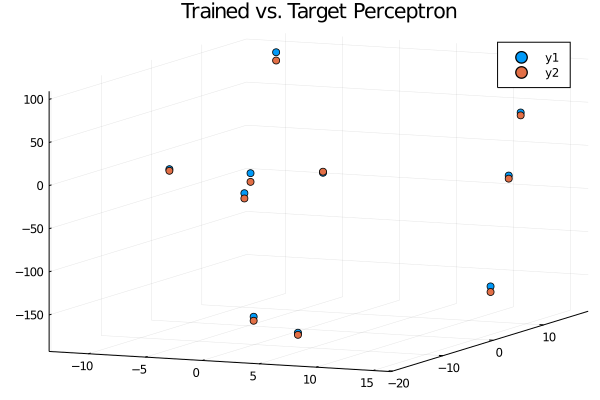

In [87]:
# Scatter plot of each
x = generate_data(10, X_RANGE, 10);
println(size(x))

println("Number of iterations: ", iters)
println("Loss: ", losses[end])
println("WITH simultaneous perceptron/policy training")
Plots.scatter(x[2,:], x[3,:], predict_linear(percep, x))
Plots.scatter!(x[2,:], x[3,:], predict_linear(targ, x))
Plots.title!("Trained vs. Target Perceptron")

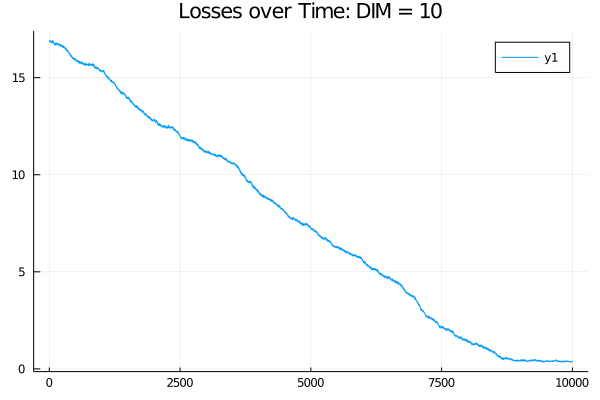

In [88]:
Plots.plot(losses)
Plots.title!("Losses over Time: DIM = 10")

### Caching 10D Linear Adaptive (DONE)

In [89]:
# cache_02("../results/final/linear_10_adaptive.json"; losses=losses, target_perceptron=targ, generated_perceptron=percep,
#             policy=pol, datapoints=x, train_policy=true, alpha=α, epsilon=ϵ, gamma=γ, dim=dim, explore_prob=explore)

## Applied Policy for Linear Model 10D

In [90]:
dim = 10
targ = generate_perceptron(dim)
iters = 20000
train_policy = false
# pol = false # STICKING TO OLD POLICY
explore = 0.5

actions, rewards, losses, percep, pol = 
    linear_experiment(
        dim, 
        targ, 
        iters, 
        explore, 
        train_policy,
        pol 
    );

NOT UPDATING POLICY!!
NOT UPDATING POLICY!!
NOT UPDATING POLICY!!
NOT UPDATING POLICY!!
NOT UPDATING POLICY!!
NOT UPDATING POLICY!!
NOT UPDATING POLICY!!
NOT UPDATING POLICY!!
NOT UPDATING POLICY!!
NOT UPDATING POLICY!!
NOT UPDATING POLICY!!
NOT UPDATING POLICY!!
NOT UPDATING POLICY!!
NOT UPDATING POLICY!!
NOT UPDATING POLICY!!
NOT UPDATING POLICY!!
NOT UPDATING POLICY!!
NOT UPDATING POLICY!!
NOT UPDATING POLICY!!
NOT UPDATING POLICY!!
NOT UPDATING POLICY!!
NOT UPDATING POLICY!!
NOT UPDATING POLICY!!
NOT UPDATING POLICY!!
NOT UPDATING POLICY!!
NOT UPDATING POLICY!!
NOT UPDATING POLICY!!
NOT UPDATING POLICY!!
NOT UPDATING POLICY!!
NOT UPDATING POLICY!!
NOT UPDATING POLICY!!
NOT UPDATING POLICY!!
NOT UPDATING POLICY!!
NOT UPDATING POLICY!!
NOT UPDATING POLICY!!
NOT UPDATING POLICY!!
NOT UPDATING POLICY!!
NOT UPDATING POLICY!!
NOT UPDATING POLICY!!
NOT UPDATING POLICY!!
NOT UPDATING POLICY!!
NOT UPDATING POLICY!!
NOT UPDATING POLICY!!
NOT UPDATING POLICY!!
NOT UPDATING POLICY!!
NOT UPDATI

NOT UPDATING POLICY!!
NOT UPDATING POLICY!!
NOT UPDATING POLICY!!
NOT UPDATING POLICY!!
NOT UPDATING POLICY!!
NOT UPDATING POLICY!!
NOT UPDATING POLICY!!
NOT UPDATING POLICY!!
NOT UPDATING POLICY!!
NOT UPDATING POLICY!!
NOT UPDATING POLICY!!
NOT UPDATING POLICY!!
NOT UPDATING POLICY!!
NOT UPDATING POLICY!!
NOT UPDATING POLICY!!
NOT UPDATING POLICY!!
NOT UPDATING POLICY!!
NOT UPDATING POLICY!!
NOT UPDATING POLICY!!
NOT UPDATING POLICY!!
NOT UPDATING POLICY!!
NOT UPDATING POLICY!!
NOT UPDATING POLICY!!
NOT UPDATING POLICY!!
NOT UPDATING POLICY!!
NOT UPDATING POLICY!!
NOT UPDATING POLICY!!
NOT UPDATING POLICY!!
NOT UPDATING POLICY!!
NOT UPDATING POLICY!!
NOT UPDATING POLICY!!
NOT UPDATING POLICY!!
NOT UPDATING POLICY!!
NOT UPDATING POLICY!!
NOT UPDATING POLICY!!
NOT UPDATING POLICY!!
NOT UPDATING POLICY!!
NOT UPDATING POLICY!!
NOT UPDATING POLICY!!
NOT UPDATING POLICY!!
NOT UPDATING POLICY!!
NOT UPDATING POLICY!!
NOT UPDATING POLICY!!
NOT UPDATING POLICY!!
NOT UPDATING POLICY!!
NOT UPDATI

NOT UPDATING POLICY!!
NOT UPDATING POLICY!!
NOT UPDATING POLICY!!
NOT UPDATING POLICY!!
NOT UPDATING POLICY!!
NOT UPDATING POLICY!!
NOT UPDATING POLICY!!
NOT UPDATING POLICY!!
NOT UPDATING POLICY!!
NOT UPDATING POLICY!!
NOT UPDATING POLICY!!
NOT UPDATING POLICY!!
NOT UPDATING POLICY!!
NOT UPDATING POLICY!!
NOT UPDATING POLICY!!
NOT UPDATING POLICY!!
NOT UPDATING POLICY!!
NOT UPDATING POLICY!!
NOT UPDATING POLICY!!
NOT UPDATING POLICY!!
NOT UPDATING POLICY!!
NOT UPDATING POLICY!!
NOT UPDATING POLICY!!
NOT UPDATING POLICY!!
NOT UPDATING POLICY!!
NOT UPDATING POLICY!!
NOT UPDATING POLICY!!
NOT UPDATING POLICY!!
NOT UPDATING POLICY!!
NOT UPDATING POLICY!!
NOT UPDATING POLICY!!
NOT UPDATING POLICY!!
NOT UPDATING POLICY!!
NOT UPDATING POLICY!!
NOT UPDATING POLICY!!
NOT UPDATING POLICY!!
NOT UPDATING POLICY!!
NOT UPDATING POLICY!!
NOT UPDATING POLICY!!
NOT UPDATING POLICY!!
NOT UPDATING POLICY!!
NOT UPDATING POLICY!!
NOT UPDATING POLICY!!
NOT UPDATING POLICY!!
NOT UPDATING POLICY!!
NOT UPDATI

NOT UPDATING POLICY!!
NOT UPDATING POLICY!!
NOT UPDATING POLICY!!
NOT UPDATING POLICY!!
NOT UPDATING POLICY!!
NOT UPDATING POLICY!!
NOT UPDATING POLICY!!
NOT UPDATING POLICY!!
NOT UPDATING POLICY!!
NOT UPDATING POLICY!!
NOT UPDATING POLICY!!
NOT UPDATING POLICY!!
NOT UPDATING POLICY!!
NOT UPDATING POLICY!!
NOT UPDATING POLICY!!
NOT UPDATING POLICY!!
NOT UPDATING POLICY!!
NOT UPDATING POLICY!!
NOT UPDATING POLICY!!
NOT UPDATING POLICY!!
NOT UPDATING POLICY!!
NOT UPDATING POLICY!!
NOT UPDATING POLICY!!
NOT UPDATING POLICY!!
NOT UPDATING POLICY!!
NOT UPDATING POLICY!!
NOT UPDATING POLICY!!
NOT UPDATING POLICY!!
NOT UPDATING POLICY!!
NOT UPDATING POLICY!!
NOT UPDATING POLICY!!
NOT UPDATING POLICY!!
NOT UPDATING POLICY!!
NOT UPDATING POLICY!!
NOT UPDATING POLICY!!
NOT UPDATING POLICY!!
NOT UPDATING POLICY!!
NOT UPDATING POLICY!!
NOT UPDATING POLICY!!
NOT UPDATING POLICY!!
NOT UPDATING POLICY!!
NOT UPDATING POLICY!!
NOT UPDATING POLICY!!
NOT UPDATING POLICY!!
NOT UPDATING POLICY!!
NOT UPDATI

NOT UPDATING POLICY!!
NOT UPDATING POLICY!!
NOT UPDATING POLICY!!
NOT UPDATING POLICY!!
NOT UPDATING POLICY!!
NOT UPDATING POLICY!!
NOT UPDATING POLICY!!
NOT UPDATING POLICY!!
NOT UPDATING POLICY!!
NOT UPDATING POLICY!!
NOT UPDATING POLICY!!
NOT UPDATING POLICY!!
NOT UPDATING POLICY!!
NOT UPDATING POLICY!!
NOT UPDATING POLICY!!
NOT UPDATING POLICY!!
NOT UPDATING POLICY!!
NOT UPDATING POLICY!!
NOT UPDATING POLICY!!
NOT UPDATING POLICY!!
NOT UPDATING POLICY!!
NOT UPDATING POLICY!!
NOT UPDATING POLICY!!
NOT UPDATING POLICY!!
NOT UPDATING POLICY!!
NOT UPDATING POLICY!!
NOT UPDATING POLICY!!
NOT UPDATING POLICY!!
NOT UPDATING POLICY!!
NOT UPDATING POLICY!!
NOT UPDATING POLICY!!
NOT UPDATING POLICY!!
NOT UPDATING POLICY!!
NOT UPDATING POLICY!!
NOT UPDATING POLICY!!
NOT UPDATING POLICY!!
NOT UPDATING POLICY!!
NOT UPDATING POLICY!!
NOT UPDATING POLICY!!
NOT UPDATING POLICY!!
NOT UPDATING POLICY!!
NOT UPDATING POLICY!!
NOT UPDATING POLICY!!
NOT UPDATING POLICY!!
NOT UPDATING POLICY!!
NOT UPDATI

NOT UPDATING POLICY!!
NOT UPDATING POLICY!!
NOT UPDATING POLICY!!
NOT UPDATING POLICY!!
NOT UPDATING POLICY!!
NOT UPDATING POLICY!!
NOT UPDATING POLICY!!
NOT UPDATING POLICY!!
NOT UPDATING POLICY!!
NOT UPDATING POLICY!!
NOT UPDATING POLICY!!
NOT UPDATING POLICY!!
NOT UPDATING POLICY!!
NOT UPDATING POLICY!!
NOT UPDATING POLICY!!
NOT UPDATING POLICY!!
NOT UPDATING POLICY!!
NOT UPDATING POLICY!!
NOT UPDATING POLICY!!
NOT UPDATING POLICY!!
NOT UPDATING POLICY!!
NOT UPDATING POLICY!!
NOT UPDATING POLICY!!
NOT UPDATING POLICY!!
NOT UPDATING POLICY!!
NOT UPDATING POLICY!!
NOT UPDATING POLICY!!
NOT UPDATING POLICY!!
NOT UPDATING POLICY!!
NOT UPDATING POLICY!!
NOT UPDATING POLICY!!
NOT UPDATING POLICY!!
NOT UPDATING POLICY!!
NOT UPDATING POLICY!!
NOT UPDATING POLICY!!
NOT UPDATING POLICY!!
NOT UPDATING POLICY!!
NOT UPDATING POLICY!!
NOT UPDATING POLICY!!
NOT UPDATING POLICY!!
NOT UPDATING POLICY!!
NOT UPDATING POLICY!!
NOT UPDATING POLICY!!
NOT UPDATING POLICY!!
NOT UPDATING POLICY!!
NOT UPDATI

NOT UPDATING POLICY!!
NOT UPDATING POLICY!!
NOT UPDATING POLICY!!
NOT UPDATING POLICY!!
NOT UPDATING POLICY!!
NOT UPDATING POLICY!!
NOT UPDATING POLICY!!
NOT UPDATING POLICY!!
NOT UPDATING POLICY!!
NOT UPDATING POLICY!!
NOT UPDATING POLICY!!
NOT UPDATING POLICY!!
NOT UPDATING POLICY!!
NOT UPDATING POLICY!!
NOT UPDATING POLICY!!
NOT UPDATING POLICY!!
NOT UPDATING POLICY!!
NOT UPDATING POLICY!!
NOT UPDATING POLICY!!
NOT UPDATING POLICY!!
NOT UPDATING POLICY!!
NOT UPDATING POLICY!!
NOT UPDATING POLICY!!
NOT UPDATING POLICY!!
NOT UPDATING POLICY!!
NOT UPDATING POLICY!!
NOT UPDATING POLICY!!
NOT UPDATING POLICY!!
NOT UPDATING POLICY!!
NOT UPDATING POLICY!!
NOT UPDATING POLICY!!
NOT UPDATING POLICY!!
NOT UPDATING POLICY!!
NOT UPDATING POLICY!!
NOT UPDATING POLICY!!
NOT UPDATING POLICY!!
NOT UPDATING POLICY!!
NOT UPDATING POLICY!!
NOT UPDATING POLICY!!
NOT UPDATING POLICY!!
NOT UPDATING POLICY!!
NOT UPDATING POLICY!!
NOT UPDATING POLICY!!
NOT UPDATING POLICY!!
NOT UPDATING POLICY!!
NOT UPDATI

NOT UPDATING POLICY!!
NOT UPDATING POLICY!!
NOT UPDATING POLICY!!
NOT UPDATING POLICY!!
NOT UPDATING POLICY!!
NOT UPDATING POLICY!!
NOT UPDATING POLICY!!
NOT UPDATING POLICY!!
NOT UPDATING POLICY!!
NOT UPDATING POLICY!!
NOT UPDATING POLICY!!
NOT UPDATING POLICY!!
NOT UPDATING POLICY!!
NOT UPDATING POLICY!!
NOT UPDATING POLICY!!
NOT UPDATING POLICY!!
NOT UPDATING POLICY!!
NOT UPDATING POLICY!!
NOT UPDATING POLICY!!
NOT UPDATING POLICY!!
NOT UPDATING POLICY!!
NOT UPDATING POLICY!!
NOT UPDATING POLICY!!
NOT UPDATING POLICY!!
NOT UPDATING POLICY!!
NOT UPDATING POLICY!!
NOT UPDATING POLICY!!
NOT UPDATING POLICY!!
NOT UPDATING POLICY!!
NOT UPDATING POLICY!!
NOT UPDATING POLICY!!
NOT UPDATING POLICY!!
NOT UPDATING POLICY!!
NOT UPDATING POLICY!!
NOT UPDATING POLICY!!
NOT UPDATING POLICY!!
NOT UPDATING POLICY!!
NOT UPDATING POLICY!!
NOT UPDATING POLICY!!
NOT UPDATING POLICY!!
NOT UPDATING POLICY!!
NOT UPDATING POLICY!!
NOT UPDATING POLICY!!
NOT UPDATING POLICY!!
NOT UPDATING POLICY!!
NOT UPDATI

NOT UPDATING POLICY!!
NOT UPDATING POLICY!!
NOT UPDATING POLICY!!
NOT UPDATING POLICY!!
NOT UPDATING POLICY!!
NOT UPDATING POLICY!!
NOT UPDATING POLICY!!
NOT UPDATING POLICY!!
NOT UPDATING POLICY!!
NOT UPDATING POLICY!!
NOT UPDATING POLICY!!
NOT UPDATING POLICY!!
NOT UPDATING POLICY!!
NOT UPDATING POLICY!!
NOT UPDATING POLICY!!
NOT UPDATING POLICY!!
NOT UPDATING POLICY!!
NOT UPDATING POLICY!!
NOT UPDATING POLICY!!
NOT UPDATING POLICY!!
NOT UPDATING POLICY!!
NOT UPDATING POLICY!!
NOT UPDATING POLICY!!
NOT UPDATING POLICY!!
NOT UPDATING POLICY!!
NOT UPDATING POLICY!!
NOT UPDATING POLICY!!
NOT UPDATING POLICY!!
NOT UPDATING POLICY!!
NOT UPDATING POLICY!!
NOT UPDATING POLICY!!
NOT UPDATING POLICY!!
NOT UPDATING POLICY!!
NOT UPDATING POLICY!!
NOT UPDATING POLICY!!
NOT UPDATING POLICY!!
NOT UPDATING POLICY!!
NOT UPDATING POLICY!!
NOT UPDATING POLICY!!
NOT UPDATING POLICY!!
NOT UPDATING POLICY!!
NOT UPDATING POLICY!!
NOT UPDATING POLICY!!
NOT UPDATING POLICY!!
NOT UPDATING POLICY!!
NOT UPDATI

NOT UPDATING POLICY!!
NOT UPDATING POLICY!!
NOT UPDATING POLICY!!
NOT UPDATING POLICY!!
NOT UPDATING POLICY!!
NOT UPDATING POLICY!!
NOT UPDATING POLICY!!
NOT UPDATING POLICY!!
NOT UPDATING POLICY!!
NOT UPDATING POLICY!!
NOT UPDATING POLICY!!
NOT UPDATING POLICY!!
NOT UPDATING POLICY!!
NOT UPDATING POLICY!!
NOT UPDATING POLICY!!
NOT UPDATING POLICY!!
NOT UPDATING POLICY!!
NOT UPDATING POLICY!!
NOT UPDATING POLICY!!
NOT UPDATING POLICY!!
NOT UPDATING POLICY!!
NOT UPDATING POLICY!!
NOT UPDATING POLICY!!
NOT UPDATING POLICY!!
NOT UPDATING POLICY!!
NOT UPDATING POLICY!!
NOT UPDATING POLICY!!
NOT UPDATING POLICY!!
NOT UPDATING POLICY!!
NOT UPDATING POLICY!!
NOT UPDATING POLICY!!
NOT UPDATING POLICY!!
NOT UPDATING POLICY!!
NOT UPDATING POLICY!!
NOT UPDATING POLICY!!
NOT UPDATING POLICY!!
NOT UPDATING POLICY!!
NOT UPDATING POLICY!!
NOT UPDATING POLICY!!
NOT UPDATING POLICY!!
NOT UPDATING POLICY!!
NOT UPDATING POLICY!!
NOT UPDATING POLICY!!
NOT UPDATING POLICY!!
NOT UPDATING POLICY!!
NOT UPDATI

NOT UPDATING POLICY!!
NOT UPDATING POLICY!!
NOT UPDATING POLICY!!
NOT UPDATING POLICY!!
NOT UPDATING POLICY!!
NOT UPDATING POLICY!!
NOT UPDATING POLICY!!
NOT UPDATING POLICY!!
NOT UPDATING POLICY!!
NOT UPDATING POLICY!!
NOT UPDATING POLICY!!
NOT UPDATING POLICY!!
NOT UPDATING POLICY!!
NOT UPDATING POLICY!!
NOT UPDATING POLICY!!
NOT UPDATING POLICY!!
NOT UPDATING POLICY!!
NOT UPDATING POLICY!!
NOT UPDATING POLICY!!
NOT UPDATING POLICY!!
NOT UPDATING POLICY!!
NOT UPDATING POLICY!!
NOT UPDATING POLICY!!
NOT UPDATING POLICY!!
NOT UPDATING POLICY!!
NOT UPDATING POLICY!!
NOT UPDATING POLICY!!
NOT UPDATING POLICY!!
NOT UPDATING POLICY!!
NOT UPDATING POLICY!!
NOT UPDATING POLICY!!
NOT UPDATING POLICY!!
NOT UPDATING POLICY!!
NOT UPDATING POLICY!!
NOT UPDATING POLICY!!
NOT UPDATING POLICY!!
NOT UPDATING POLICY!!
NOT UPDATING POLICY!!
NOT UPDATING POLICY!!
NOT UPDATING POLICY!!
NOT UPDATING POLICY!!
NOT UPDATING POLICY!!
NOT UPDATING POLICY!!
NOT UPDATING POLICY!!
NOT UPDATING POLICY!!
NOT UPDATI

NOT UPDATING POLICY!!
NOT UPDATING POLICY!!
NOT UPDATING POLICY!!
NOT UPDATING POLICY!!
NOT UPDATING POLICY!!
NOT UPDATING POLICY!!
NOT UPDATING POLICY!!
NOT UPDATING POLICY!!
NOT UPDATING POLICY!!
NOT UPDATING POLICY!!
NOT UPDATING POLICY!!
NOT UPDATING POLICY!!
NOT UPDATING POLICY!!
NOT UPDATING POLICY!!
NOT UPDATING POLICY!!
NOT UPDATING POLICY!!
NOT UPDATING POLICY!!
NOT UPDATING POLICY!!
NOT UPDATING POLICY!!
NOT UPDATING POLICY!!
NOT UPDATING POLICY!!
NOT UPDATING POLICY!!
NOT UPDATING POLICY!!
NOT UPDATING POLICY!!
NOT UPDATING POLICY!!
NOT UPDATING POLICY!!
NOT UPDATING POLICY!!
NOT UPDATING POLICY!!
NOT UPDATING POLICY!!
NOT UPDATING POLICY!!
NOT UPDATING POLICY!!
NOT UPDATING POLICY!!
NOT UPDATING POLICY!!
NOT UPDATING POLICY!!
NOT UPDATING POLICY!!
NOT UPDATING POLICY!!
NOT UPDATING POLICY!!
NOT UPDATING POLICY!!
NOT UPDATING POLICY!!
NOT UPDATING POLICY!!
NOT UPDATING POLICY!!
NOT UPDATING POLICY!!
NOT UPDATING POLICY!!
NOT UPDATING POLICY!!
NOT UPDATING POLICY!!
NOT UPDATI

NOT UPDATING POLICY!!
NOT UPDATING POLICY!!
NOT UPDATING POLICY!!
NOT UPDATING POLICY!!
NOT UPDATING POLICY!!
NOT UPDATING POLICY!!
NOT UPDATING POLICY!!
NOT UPDATING POLICY!!
NOT UPDATING POLICY!!
NOT UPDATING POLICY!!
NOT UPDATING POLICY!!
NOT UPDATING POLICY!!
NOT UPDATING POLICY!!
NOT UPDATING POLICY!!
NOT UPDATING POLICY!!
NOT UPDATING POLICY!!
NOT UPDATING POLICY!!
NOT UPDATING POLICY!!
NOT UPDATING POLICY!!
NOT UPDATING POLICY!!
NOT UPDATING POLICY!!
NOT UPDATING POLICY!!
NOT UPDATING POLICY!!
NOT UPDATING POLICY!!
NOT UPDATING POLICY!!
NOT UPDATING POLICY!!
NOT UPDATING POLICY!!
NOT UPDATING POLICY!!
NOT UPDATING POLICY!!
NOT UPDATING POLICY!!
NOT UPDATING POLICY!!
NOT UPDATING POLICY!!
NOT UPDATING POLICY!!
NOT UPDATING POLICY!!
NOT UPDATING POLICY!!
NOT UPDATING POLICY!!
NOT UPDATING POLICY!!
NOT UPDATING POLICY!!
NOT UPDATING POLICY!!
NOT UPDATING POLICY!!
NOT UPDATING POLICY!!
NOT UPDATING POLICY!!
NOT UPDATING POLICY!!
NOT UPDATING POLICY!!
NOT UPDATING POLICY!!
NOT UPDATI

NOT UPDATING POLICY!!
NOT UPDATING POLICY!!
NOT UPDATING POLICY!!
NOT UPDATING POLICY!!
NOT UPDATING POLICY!!
NOT UPDATING POLICY!!
NOT UPDATING POLICY!!
NOT UPDATING POLICY!!
NOT UPDATING POLICY!!
NOT UPDATING POLICY!!
NOT UPDATING POLICY!!
NOT UPDATING POLICY!!
NOT UPDATING POLICY!!
NOT UPDATING POLICY!!
NOT UPDATING POLICY!!
NOT UPDATING POLICY!!
NOT UPDATING POLICY!!
NOT UPDATING POLICY!!
NOT UPDATING POLICY!!
NOT UPDATING POLICY!!
NOT UPDATING POLICY!!
NOT UPDATING POLICY!!
NOT UPDATING POLICY!!
NOT UPDATING POLICY!!
NOT UPDATING POLICY!!
NOT UPDATING POLICY!!
NOT UPDATING POLICY!!
NOT UPDATING POLICY!!
NOT UPDATING POLICY!!
NOT UPDATING POLICY!!
NOT UPDATING POLICY!!
NOT UPDATING POLICY!!
NOT UPDATING POLICY!!
NOT UPDATING POLICY!!
NOT UPDATING POLICY!!
NOT UPDATING POLICY!!
NOT UPDATING POLICY!!
NOT UPDATING POLICY!!
NOT UPDATING POLICY!!
NOT UPDATING POLICY!!
NOT UPDATING POLICY!!
NOT UPDATING POLICY!!
NOT UPDATING POLICY!!
NOT UPDATING POLICY!!
NOT UPDATING POLICY!!
NOT UPDATI

NOT UPDATING POLICY!!
NOT UPDATING POLICY!!
NOT UPDATING POLICY!!
NOT UPDATING POLICY!!
NOT UPDATING POLICY!!
NOT UPDATING POLICY!!
NOT UPDATING POLICY!!
NOT UPDATING POLICY!!
NOT UPDATING POLICY!!
NOT UPDATING POLICY!!
NOT UPDATING POLICY!!
NOT UPDATING POLICY!!
NOT UPDATING POLICY!!
NOT UPDATING POLICY!!
NOT UPDATING POLICY!!
NOT UPDATING POLICY!!
NOT UPDATING POLICY!!
NOT UPDATING POLICY!!
NOT UPDATING POLICY!!
NOT UPDATING POLICY!!
NOT UPDATING POLICY!!
NOT UPDATING POLICY!!
NOT UPDATING POLICY!!
NOT UPDATING POLICY!!
NOT UPDATING POLICY!!
NOT UPDATING POLICY!!
NOT UPDATING POLICY!!
NOT UPDATING POLICY!!
NOT UPDATING POLICY!!
NOT UPDATING POLICY!!
NOT UPDATING POLICY!!
NOT UPDATING POLICY!!
NOT UPDATING POLICY!!
NOT UPDATING POLICY!!
NOT UPDATING POLICY!!
NOT UPDATING POLICY!!
NOT UPDATING POLICY!!
NOT UPDATING POLICY!!
NOT UPDATING POLICY!!
NOT UPDATING POLICY!!
NOT UPDATING POLICY!!
NOT UPDATING POLICY!!
NOT UPDATING POLICY!!
NOT UPDATING POLICY!!
NOT UPDATING POLICY!!
NOT UPDATI

NOT UPDATING POLICY!!
NOT UPDATING POLICY!!
NOT UPDATING POLICY!!
NOT UPDATING POLICY!!
NOT UPDATING POLICY!!
NOT UPDATING POLICY!!
NOT UPDATING POLICY!!
NOT UPDATING POLICY!!
NOT UPDATING POLICY!!
NOT UPDATING POLICY!!
NOT UPDATING POLICY!!
NOT UPDATING POLICY!!
NOT UPDATING POLICY!!
NOT UPDATING POLICY!!
NOT UPDATING POLICY!!
NOT UPDATING POLICY!!
NOT UPDATING POLICY!!
NOT UPDATING POLICY!!
NOT UPDATING POLICY!!
NOT UPDATING POLICY!!
NOT UPDATING POLICY!!
NOT UPDATING POLICY!!
NOT UPDATING POLICY!!
NOT UPDATING POLICY!!
NOT UPDATING POLICY!!
NOT UPDATING POLICY!!
NOT UPDATING POLICY!!
NOT UPDATING POLICY!!
NOT UPDATING POLICY!!
NOT UPDATING POLICY!!
NOT UPDATING POLICY!!
NOT UPDATING POLICY!!
NOT UPDATING POLICY!!
NOT UPDATING POLICY!!
NOT UPDATING POLICY!!
NOT UPDATING POLICY!!
NOT UPDATING POLICY!!
NOT UPDATING POLICY!!
NOT UPDATING POLICY!!
NOT UPDATING POLICY!!
NOT UPDATING POLICY!!
NOT UPDATING POLICY!!
NOT UPDATING POLICY!!
NOT UPDATING POLICY!!
NOT UPDATING POLICY!!
NOT UPDATI

NOT UPDATING POLICY!!
NOT UPDATING POLICY!!
NOT UPDATING POLICY!!
NOT UPDATING POLICY!!
NOT UPDATING POLICY!!
NOT UPDATING POLICY!!
NOT UPDATING POLICY!!
NOT UPDATING POLICY!!
NOT UPDATING POLICY!!
NOT UPDATING POLICY!!
NOT UPDATING POLICY!!
NOT UPDATING POLICY!!
NOT UPDATING POLICY!!
NOT UPDATING POLICY!!
NOT UPDATING POLICY!!
NOT UPDATING POLICY!!
NOT UPDATING POLICY!!
NOT UPDATING POLICY!!
NOT UPDATING POLICY!!
NOT UPDATING POLICY!!
NOT UPDATING POLICY!!
NOT UPDATING POLICY!!
NOT UPDATING POLICY!!
NOT UPDATING POLICY!!
NOT UPDATING POLICY!!
NOT UPDATING POLICY!!
NOT UPDATING POLICY!!
NOT UPDATING POLICY!!
NOT UPDATING POLICY!!
NOT UPDATING POLICY!!
NOT UPDATING POLICY!!
NOT UPDATING POLICY!!
NOT UPDATING POLICY!!
NOT UPDATING POLICY!!
NOT UPDATING POLICY!!
NOT UPDATING POLICY!!
NOT UPDATING POLICY!!
NOT UPDATING POLICY!!
NOT UPDATING POLICY!!
NOT UPDATING POLICY!!
NOT UPDATING POLICY!!
NOT UPDATING POLICY!!
NOT UPDATING POLICY!!
NOT UPDATING POLICY!!
NOT UPDATING POLICY!!
NOT UPDATI

NOT UPDATING POLICY!!
NOT UPDATING POLICY!!
NOT UPDATING POLICY!!
NOT UPDATING POLICY!!
NOT UPDATING POLICY!!
NOT UPDATING POLICY!!
NOT UPDATING POLICY!!
NOT UPDATING POLICY!!
NOT UPDATING POLICY!!
NOT UPDATING POLICY!!
NOT UPDATING POLICY!!
NOT UPDATING POLICY!!
NOT UPDATING POLICY!!
NOT UPDATING POLICY!!
NOT UPDATING POLICY!!
NOT UPDATING POLICY!!
NOT UPDATING POLICY!!
NOT UPDATING POLICY!!
NOT UPDATING POLICY!!
NOT UPDATING POLICY!!
NOT UPDATING POLICY!!
NOT UPDATING POLICY!!
NOT UPDATING POLICY!!
NOT UPDATING POLICY!!
NOT UPDATING POLICY!!
NOT UPDATING POLICY!!
NOT UPDATING POLICY!!
NOT UPDATING POLICY!!
NOT UPDATING POLICY!!
NOT UPDATING POLICY!!
NOT UPDATING POLICY!!
NOT UPDATING POLICY!!
NOT UPDATING POLICY!!
NOT UPDATING POLICY!!
NOT UPDATING POLICY!!
NOT UPDATING POLICY!!
NOT UPDATING POLICY!!
NOT UPDATING POLICY!!
NOT UPDATING POLICY!!
NOT UPDATING POLICY!!
NOT UPDATING POLICY!!
NOT UPDATING POLICY!!
NOT UPDATING POLICY!!
NOT UPDATING POLICY!!
NOT UPDATING POLICY!!
NOT UPDATI

NOT UPDATING POLICY!!
NOT UPDATING POLICY!!
NOT UPDATING POLICY!!
NOT UPDATING POLICY!!
NOT UPDATING POLICY!!
NOT UPDATING POLICY!!
NOT UPDATING POLICY!!
NOT UPDATING POLICY!!
NOT UPDATING POLICY!!
NOT UPDATING POLICY!!
NOT UPDATING POLICY!!
NOT UPDATING POLICY!!
NOT UPDATING POLICY!!
NOT UPDATING POLICY!!
NOT UPDATING POLICY!!
NOT UPDATING POLICY!!
NOT UPDATING POLICY!!
NOT UPDATING POLICY!!
NOT UPDATING POLICY!!
NOT UPDATING POLICY!!
NOT UPDATING POLICY!!
NOT UPDATING POLICY!!
NOT UPDATING POLICY!!
NOT UPDATING POLICY!!
NOT UPDATING POLICY!!
NOT UPDATING POLICY!!
NOT UPDATING POLICY!!
NOT UPDATING POLICY!!
NOT UPDATING POLICY!!
NOT UPDATING POLICY!!
NOT UPDATING POLICY!!
NOT UPDATING POLICY!!
NOT UPDATING POLICY!!
NOT UPDATING POLICY!!
NOT UPDATING POLICY!!
NOT UPDATING POLICY!!
NOT UPDATING POLICY!!
NOT UPDATING POLICY!!
NOT UPDATING POLICY!!
NOT UPDATING POLICY!!
NOT UPDATING POLICY!!
NOT UPDATING POLICY!!
NOT UPDATING POLICY!!
NOT UPDATING POLICY!!
NOT UPDATING POLICY!!
NOT UPDATI

NOT UPDATING POLICY!!
NOT UPDATING POLICY!!
NOT UPDATING POLICY!!
NOT UPDATING POLICY!!
NOT UPDATING POLICY!!
NOT UPDATING POLICY!!
NOT UPDATING POLICY!!
NOT UPDATING POLICY!!
NOT UPDATING POLICY!!
NOT UPDATING POLICY!!
NOT UPDATING POLICY!!
NOT UPDATING POLICY!!
NOT UPDATING POLICY!!
NOT UPDATING POLICY!!
NOT UPDATING POLICY!!
NOT UPDATING POLICY!!
NOT UPDATING POLICY!!
NOT UPDATING POLICY!!
NOT UPDATING POLICY!!
NOT UPDATING POLICY!!
NOT UPDATING POLICY!!
NOT UPDATING POLICY!!
NOT UPDATING POLICY!!
NOT UPDATING POLICY!!
NOT UPDATING POLICY!!
NOT UPDATING POLICY!!
NOT UPDATING POLICY!!
NOT UPDATING POLICY!!
NOT UPDATING POLICY!!
NOT UPDATING POLICY!!
NOT UPDATING POLICY!!
NOT UPDATING POLICY!!
NOT UPDATING POLICY!!
NOT UPDATING POLICY!!
NOT UPDATING POLICY!!
NOT UPDATING POLICY!!
NOT UPDATING POLICY!!
NOT UPDATING POLICY!!
NOT UPDATING POLICY!!
NOT UPDATING POLICY!!
NOT UPDATING POLICY!!
NOT UPDATING POLICY!!
NOT UPDATING POLICY!!
NOT UPDATING POLICY!!
NOT UPDATING POLICY!!
NOT UPDATI

NOT UPDATING POLICY!!
NOT UPDATING POLICY!!
NOT UPDATING POLICY!!
NOT UPDATING POLICY!!
NOT UPDATING POLICY!!
NOT UPDATING POLICY!!
NOT UPDATING POLICY!!
NOT UPDATING POLICY!!
NOT UPDATING POLICY!!
NOT UPDATING POLICY!!
NOT UPDATING POLICY!!
NOT UPDATING POLICY!!
NOT UPDATING POLICY!!
NOT UPDATING POLICY!!
NOT UPDATING POLICY!!
NOT UPDATING POLICY!!
NOT UPDATING POLICY!!
NOT UPDATING POLICY!!
NOT UPDATING POLICY!!
NOT UPDATING POLICY!!
NOT UPDATING POLICY!!
NOT UPDATING POLICY!!
NOT UPDATING POLICY!!
NOT UPDATING POLICY!!
NOT UPDATING POLICY!!
NOT UPDATING POLICY!!
NOT UPDATING POLICY!!
NOT UPDATING POLICY!!
NOT UPDATING POLICY!!
NOT UPDATING POLICY!!
NOT UPDATING POLICY!!
NOT UPDATING POLICY!!
NOT UPDATING POLICY!!
NOT UPDATING POLICY!!
NOT UPDATING POLICY!!
NOT UPDATING POLICY!!
NOT UPDATING POLICY!!
NOT UPDATING POLICY!!
NOT UPDATING POLICY!!
NOT UPDATING POLICY!!
NOT UPDATING POLICY!!
NOT UPDATING POLICY!!
NOT UPDATING POLICY!!
NOT UPDATING POLICY!!
NOT UPDATING POLICY!!
NOT UPDATI

NOT UPDATING POLICY!!
NOT UPDATING POLICY!!
NOT UPDATING POLICY!!
NOT UPDATING POLICY!!
NOT UPDATING POLICY!!
NOT UPDATING POLICY!!
NOT UPDATING POLICY!!
NOT UPDATING POLICY!!
NOT UPDATING POLICY!!
NOT UPDATING POLICY!!
NOT UPDATING POLICY!!
NOT UPDATING POLICY!!
NOT UPDATING POLICY!!
NOT UPDATING POLICY!!
NOT UPDATING POLICY!!
NOT UPDATING POLICY!!
NOT UPDATING POLICY!!
NOT UPDATING POLICY!!
NOT UPDATING POLICY!!
NOT UPDATING POLICY!!
NOT UPDATING POLICY!!
NOT UPDATING POLICY!!
NOT UPDATING POLICY!!
NOT UPDATING POLICY!!
NOT UPDATING POLICY!!
NOT UPDATING POLICY!!
NOT UPDATING POLICY!!
NOT UPDATING POLICY!!
NOT UPDATING POLICY!!
NOT UPDATING POLICY!!
NOT UPDATING POLICY!!
NOT UPDATING POLICY!!
NOT UPDATING POLICY!!
NOT UPDATING POLICY!!
NOT UPDATING POLICY!!
NOT UPDATING POLICY!!
NOT UPDATING POLICY!!
NOT UPDATING POLICY!!
NOT UPDATING POLICY!!
NOT UPDATING POLICY!!
NOT UPDATING POLICY!!
NOT UPDATING POLICY!!
NOT UPDATING POLICY!!
NOT UPDATING POLICY!!
NOT UPDATING POLICY!!
NOT UPDATI

NOT UPDATING POLICY!!
NOT UPDATING POLICY!!
NOT UPDATING POLICY!!
NOT UPDATING POLICY!!
NOT UPDATING POLICY!!
NOT UPDATING POLICY!!
NOT UPDATING POLICY!!
NOT UPDATING POLICY!!
NOT UPDATING POLICY!!
NOT UPDATING POLICY!!
NOT UPDATING POLICY!!
NOT UPDATING POLICY!!
NOT UPDATING POLICY!!
NOT UPDATING POLICY!!
NOT UPDATING POLICY!!
NOT UPDATING POLICY!!
NOT UPDATING POLICY!!
NOT UPDATING POLICY!!
NOT UPDATING POLICY!!
NOT UPDATING POLICY!!
NOT UPDATING POLICY!!
NOT UPDATING POLICY!!
NOT UPDATING POLICY!!
NOT UPDATING POLICY!!
NOT UPDATING POLICY!!
NOT UPDATING POLICY!!
NOT UPDATING POLICY!!
NOT UPDATING POLICY!!
NOT UPDATING POLICY!!
NOT UPDATING POLICY!!
NOT UPDATING POLICY!!
NOT UPDATING POLICY!!
NOT UPDATING POLICY!!
NOT UPDATING POLICY!!
NOT UPDATING POLICY!!
NOT UPDATING POLICY!!
NOT UPDATING POLICY!!
NOT UPDATING POLICY!!
NOT UPDATING POLICY!!
NOT UPDATING POLICY!!
NOT UPDATING POLICY!!
NOT UPDATING POLICY!!
NOT UPDATING POLICY!!
NOT UPDATING POLICY!!
NOT UPDATING POLICY!!
NOT UPDATI

NOT UPDATING POLICY!!
NOT UPDATING POLICY!!
NOT UPDATING POLICY!!
NOT UPDATING POLICY!!
NOT UPDATING POLICY!!
NOT UPDATING POLICY!!
NOT UPDATING POLICY!!
NOT UPDATING POLICY!!
NOT UPDATING POLICY!!
NOT UPDATING POLICY!!
NOT UPDATING POLICY!!
NOT UPDATING POLICY!!
NOT UPDATING POLICY!!
NOT UPDATING POLICY!!
NOT UPDATING POLICY!!
NOT UPDATING POLICY!!
NOT UPDATING POLICY!!
NOT UPDATING POLICY!!
NOT UPDATING POLICY!!
NOT UPDATING POLICY!!
NOT UPDATING POLICY!!
NOT UPDATING POLICY!!
NOT UPDATING POLICY!!
NOT UPDATING POLICY!!
NOT UPDATING POLICY!!
NOT UPDATING POLICY!!
NOT UPDATING POLICY!!
NOT UPDATING POLICY!!
NOT UPDATING POLICY!!
NOT UPDATING POLICY!!
NOT UPDATING POLICY!!
NOT UPDATING POLICY!!
NOT UPDATING POLICY!!
NOT UPDATING POLICY!!
NOT UPDATING POLICY!!
NOT UPDATING POLICY!!
NOT UPDATING POLICY!!
NOT UPDATING POLICY!!
NOT UPDATING POLICY!!
NOT UPDATING POLICY!!
NOT UPDATING POLICY!!
NOT UPDATING POLICY!!
NOT UPDATING POLICY!!
NOT UPDATING POLICY!!
NOT UPDATING POLICY!!
NOT UPDATI

NOT UPDATING POLICY!!
NOT UPDATING POLICY!!
NOT UPDATING POLICY!!
NOT UPDATING POLICY!!
NOT UPDATING POLICY!!
NOT UPDATING POLICY!!
NOT UPDATING POLICY!!
NOT UPDATING POLICY!!
NOT UPDATING POLICY!!
NOT UPDATING POLICY!!
NOT UPDATING POLICY!!
NOT UPDATING POLICY!!
NOT UPDATING POLICY!!
NOT UPDATING POLICY!!
NOT UPDATING POLICY!!
NOT UPDATING POLICY!!
NOT UPDATING POLICY!!
NOT UPDATING POLICY!!
NOT UPDATING POLICY!!
NOT UPDATING POLICY!!
NOT UPDATING POLICY!!
NOT UPDATING POLICY!!
NOT UPDATING POLICY!!
NOT UPDATING POLICY!!
NOT UPDATING POLICY!!
NOT UPDATING POLICY!!
NOT UPDATING POLICY!!
NOT UPDATING POLICY!!
NOT UPDATING POLICY!!
NOT UPDATING POLICY!!
NOT UPDATING POLICY!!
NOT UPDATING POLICY!!
NOT UPDATING POLICY!!
NOT UPDATING POLICY!!
NOT UPDATING POLICY!!
NOT UPDATING POLICY!!
NOT UPDATING POLICY!!
NOT UPDATING POLICY!!
NOT UPDATING POLICY!!
NOT UPDATING POLICY!!
NOT UPDATING POLICY!!
NOT UPDATING POLICY!!
NOT UPDATING POLICY!!
NOT UPDATING POLICY!!
NOT UPDATING POLICY!!
NOT UPDATI

NOT UPDATING POLICY!!
NOT UPDATING POLICY!!
NOT UPDATING POLICY!!
NOT UPDATING POLICY!!
NOT UPDATING POLICY!!
NOT UPDATING POLICY!!
NOT UPDATING POLICY!!
NOT UPDATING POLICY!!
NOT UPDATING POLICY!!
NOT UPDATING POLICY!!
NOT UPDATING POLICY!!
NOT UPDATING POLICY!!
NOT UPDATING POLICY!!
NOT UPDATING POLICY!!
NOT UPDATING POLICY!!
NOT UPDATING POLICY!!
NOT UPDATING POLICY!!
NOT UPDATING POLICY!!
NOT UPDATING POLICY!!
NOT UPDATING POLICY!!
NOT UPDATING POLICY!!
NOT UPDATING POLICY!!
NOT UPDATING POLICY!!
NOT UPDATING POLICY!!
NOT UPDATING POLICY!!
NOT UPDATING POLICY!!
NOT UPDATING POLICY!!
NOT UPDATING POLICY!!
NOT UPDATING POLICY!!
NOT UPDATING POLICY!!
NOT UPDATING POLICY!!
NOT UPDATING POLICY!!
NOT UPDATING POLICY!!
NOT UPDATING POLICY!!
NOT UPDATING POLICY!!
NOT UPDATING POLICY!!
NOT UPDATING POLICY!!
NOT UPDATING POLICY!!
NOT UPDATING POLICY!!
NOT UPDATING POLICY!!
NOT UPDATING POLICY!!
NOT UPDATING POLICY!!
NOT UPDATING POLICY!!
NOT UPDATING POLICY!!
NOT UPDATING POLICY!!
NOT UPDATI

NOT UPDATING POLICY!!
NOT UPDATING POLICY!!
NOT UPDATING POLICY!!
NOT UPDATING POLICY!!
NOT UPDATING POLICY!!
NOT UPDATING POLICY!!
NOT UPDATING POLICY!!
NOT UPDATING POLICY!!
NOT UPDATING POLICY!!
NOT UPDATING POLICY!!
NOT UPDATING POLICY!!
NOT UPDATING POLICY!!
NOT UPDATING POLICY!!
NOT UPDATING POLICY!!
NOT UPDATING POLICY!!
NOT UPDATING POLICY!!
NOT UPDATING POLICY!!
NOT UPDATING POLICY!!
NOT UPDATING POLICY!!
NOT UPDATING POLICY!!
NOT UPDATING POLICY!!
NOT UPDATING POLICY!!
NOT UPDATING POLICY!!
NOT UPDATING POLICY!!
NOT UPDATING POLICY!!
NOT UPDATING POLICY!!
NOT UPDATING POLICY!!
NOT UPDATING POLICY!!
NOT UPDATING POLICY!!
NOT UPDATING POLICY!!
NOT UPDATING POLICY!!
NOT UPDATING POLICY!!
NOT UPDATING POLICY!!
NOT UPDATING POLICY!!
NOT UPDATING POLICY!!
NOT UPDATING POLICY!!
NOT UPDATING POLICY!!
NOT UPDATING POLICY!!
NOT UPDATING POLICY!!
NOT UPDATING POLICY!!
NOT UPDATING POLICY!!
NOT UPDATING POLICY!!
NOT UPDATING POLICY!!
NOT UPDATING POLICY!!
NOT UPDATING POLICY!!
NOT UPDATI

NOT UPDATING POLICY!!
NOT UPDATING POLICY!!
NOT UPDATING POLICY!!
NOT UPDATING POLICY!!
NOT UPDATING POLICY!!
NOT UPDATING POLICY!!
NOT UPDATING POLICY!!
NOT UPDATING POLICY!!
NOT UPDATING POLICY!!
NOT UPDATING POLICY!!
NOT UPDATING POLICY!!
NOT UPDATING POLICY!!
NOT UPDATING POLICY!!
NOT UPDATING POLICY!!
NOT UPDATING POLICY!!
NOT UPDATING POLICY!!
NOT UPDATING POLICY!!
NOT UPDATING POLICY!!
NOT UPDATING POLICY!!
NOT UPDATING POLICY!!
NOT UPDATING POLICY!!
NOT UPDATING POLICY!!
NOT UPDATING POLICY!!
NOT UPDATING POLICY!!
NOT UPDATING POLICY!!
NOT UPDATING POLICY!!
NOT UPDATING POLICY!!
NOT UPDATING POLICY!!
NOT UPDATING POLICY!!
NOT UPDATING POLICY!!
NOT UPDATING POLICY!!
NOT UPDATING POLICY!!
NOT UPDATING POLICY!!
NOT UPDATING POLICY!!
NOT UPDATING POLICY!!
NOT UPDATING POLICY!!
NOT UPDATING POLICY!!
NOT UPDATING POLICY!!
NOT UPDATING POLICY!!
NOT UPDATING POLICY!!
NOT UPDATING POLICY!!
NOT UPDATING POLICY!!
NOT UPDATING POLICY!!
NOT UPDATING POLICY!!
NOT UPDATING POLICY!!
NOT UPDATI

NOT UPDATING POLICY!!
NOT UPDATING POLICY!!
NOT UPDATING POLICY!!
NOT UPDATING POLICY!!
NOT UPDATING POLICY!!
NOT UPDATING POLICY!!
NOT UPDATING POLICY!!
NOT UPDATING POLICY!!
NOT UPDATING POLICY!!
NOT UPDATING POLICY!!
NOT UPDATING POLICY!!
NOT UPDATING POLICY!!
NOT UPDATING POLICY!!
NOT UPDATING POLICY!!
NOT UPDATING POLICY!!
NOT UPDATING POLICY!!
NOT UPDATING POLICY!!
NOT UPDATING POLICY!!
NOT UPDATING POLICY!!
NOT UPDATING POLICY!!
NOT UPDATING POLICY!!
NOT UPDATING POLICY!!
NOT UPDATING POLICY!!
NOT UPDATING POLICY!!
NOT UPDATING POLICY!!
NOT UPDATING POLICY!!
NOT UPDATING POLICY!!
NOT UPDATING POLICY!!
NOT UPDATING POLICY!!
NOT UPDATING POLICY!!
NOT UPDATING POLICY!!
NOT UPDATING POLICY!!
NOT UPDATING POLICY!!
NOT UPDATING POLICY!!
NOT UPDATING POLICY!!
NOT UPDATING POLICY!!
NOT UPDATING POLICY!!
NOT UPDATING POLICY!!
NOT UPDATING POLICY!!
NOT UPDATING POLICY!!
NOT UPDATING POLICY!!
NOT UPDATING POLICY!!
NOT UPDATING POLICY!!
NOT UPDATING POLICY!!
NOT UPDATING POLICY!!
NOT UPDATI

NOT UPDATING POLICY!!
NOT UPDATING POLICY!!
NOT UPDATING POLICY!!
NOT UPDATING POLICY!!
NOT UPDATING POLICY!!
NOT UPDATING POLICY!!
NOT UPDATING POLICY!!
NOT UPDATING POLICY!!
NOT UPDATING POLICY!!
NOT UPDATING POLICY!!
NOT UPDATING POLICY!!
NOT UPDATING POLICY!!
NOT UPDATING POLICY!!
NOT UPDATING POLICY!!
NOT UPDATING POLICY!!
NOT UPDATING POLICY!!
NOT UPDATING POLICY!!
NOT UPDATING POLICY!!
NOT UPDATING POLICY!!
NOT UPDATING POLICY!!
NOT UPDATING POLICY!!
NOT UPDATING POLICY!!
NOT UPDATING POLICY!!
NOT UPDATING POLICY!!
NOT UPDATING POLICY!!
NOT UPDATING POLICY!!
NOT UPDATING POLICY!!
NOT UPDATING POLICY!!
NOT UPDATING POLICY!!
NOT UPDATING POLICY!!
NOT UPDATING POLICY!!
NOT UPDATING POLICY!!
NOT UPDATING POLICY!!
NOT UPDATING POLICY!!
NOT UPDATING POLICY!!
NOT UPDATING POLICY!!
NOT UPDATING POLICY!!
NOT UPDATING POLICY!!
NOT UPDATING POLICY!!
NOT UPDATING POLICY!!
NOT UPDATING POLICY!!
NOT UPDATING POLICY!!
NOT UPDATING POLICY!!
NOT UPDATING POLICY!!
NOT UPDATING POLICY!!
NOT UPDATI

NOT UPDATING POLICY!!
NOT UPDATING POLICY!!
NOT UPDATING POLICY!!
NOT UPDATING POLICY!!
NOT UPDATING POLICY!!
NOT UPDATING POLICY!!
NOT UPDATING POLICY!!
NOT UPDATING POLICY!!
NOT UPDATING POLICY!!
NOT UPDATING POLICY!!
NOT UPDATING POLICY!!
NOT UPDATING POLICY!!
NOT UPDATING POLICY!!
NOT UPDATING POLICY!!
NOT UPDATING POLICY!!
NOT UPDATING POLICY!!
NOT UPDATING POLICY!!
NOT UPDATING POLICY!!
NOT UPDATING POLICY!!
NOT UPDATING POLICY!!
NOT UPDATING POLICY!!
NOT UPDATING POLICY!!
NOT UPDATING POLICY!!
NOT UPDATING POLICY!!
NOT UPDATING POLICY!!
NOT UPDATING POLICY!!
NOT UPDATING POLICY!!
NOT UPDATING POLICY!!
NOT UPDATING POLICY!!
NOT UPDATING POLICY!!
NOT UPDATING POLICY!!
NOT UPDATING POLICY!!
NOT UPDATING POLICY!!
NOT UPDATING POLICY!!
NOT UPDATING POLICY!!
NOT UPDATING POLICY!!
NOT UPDATING POLICY!!
NOT UPDATING POLICY!!
NOT UPDATING POLICY!!
NOT UPDATING POLICY!!
NOT UPDATING POLICY!!
NOT UPDATING POLICY!!
NOT UPDATING POLICY!!
NOT UPDATING POLICY!!
NOT UPDATING POLICY!!
NOT UPDATI

NOT UPDATING POLICY!!
NOT UPDATING POLICY!!
NOT UPDATING POLICY!!
NOT UPDATING POLICY!!
NOT UPDATING POLICY!!
NOT UPDATING POLICY!!
NOT UPDATING POLICY!!
NOT UPDATING POLICY!!
NOT UPDATING POLICY!!
NOT UPDATING POLICY!!
NOT UPDATING POLICY!!
NOT UPDATING POLICY!!
NOT UPDATING POLICY!!
NOT UPDATING POLICY!!
NOT UPDATING POLICY!!
NOT UPDATING POLICY!!
NOT UPDATING POLICY!!
NOT UPDATING POLICY!!
NOT UPDATING POLICY!!
NOT UPDATING POLICY!!
NOT UPDATING POLICY!!
NOT UPDATING POLICY!!
NOT UPDATING POLICY!!
NOT UPDATING POLICY!!
NOT UPDATING POLICY!!
NOT UPDATING POLICY!!
NOT UPDATING POLICY!!
NOT UPDATING POLICY!!
NOT UPDATING POLICY!!
NOT UPDATING POLICY!!
NOT UPDATING POLICY!!
NOT UPDATING POLICY!!
NOT UPDATING POLICY!!
NOT UPDATING POLICY!!
NOT UPDATING POLICY!!
NOT UPDATING POLICY!!
NOT UPDATING POLICY!!
NOT UPDATING POLICY!!
NOT UPDATING POLICY!!
NOT UPDATING POLICY!!
NOT UPDATING POLICY!!
NOT UPDATING POLICY!!
NOT UPDATING POLICY!!
NOT UPDATING POLICY!!
NOT UPDATING POLICY!!
NOT UPDATI

NOT UPDATING POLICY!!
NOT UPDATING POLICY!!
NOT UPDATING POLICY!!
NOT UPDATING POLICY!!
NOT UPDATING POLICY!!
NOT UPDATING POLICY!!
NOT UPDATING POLICY!!
NOT UPDATING POLICY!!
NOT UPDATING POLICY!!
NOT UPDATING POLICY!!
NOT UPDATING POLICY!!
NOT UPDATING POLICY!!
NOT UPDATING POLICY!!
NOT UPDATING POLICY!!
NOT UPDATING POLICY!!
NOT UPDATING POLICY!!
NOT UPDATING POLICY!!
NOT UPDATING POLICY!!
NOT UPDATING POLICY!!
NOT UPDATING POLICY!!
NOT UPDATING POLICY!!
NOT UPDATING POLICY!!
NOT UPDATING POLICY!!
NOT UPDATING POLICY!!
NOT UPDATING POLICY!!
NOT UPDATING POLICY!!
NOT UPDATING POLICY!!
NOT UPDATING POLICY!!
NOT UPDATING POLICY!!
NOT UPDATING POLICY!!
NOT UPDATING POLICY!!
NOT UPDATING POLICY!!
NOT UPDATING POLICY!!
NOT UPDATING POLICY!!
NOT UPDATING POLICY!!
NOT UPDATING POLICY!!
NOT UPDATING POLICY!!
NOT UPDATING POLICY!!
NOT UPDATING POLICY!!
NOT UPDATING POLICY!!
NOT UPDATING POLICY!!
NOT UPDATING POLICY!!
NOT UPDATING POLICY!!
NOT UPDATING POLICY!!
NOT UPDATING POLICY!!
NOT UPDATI

NOT UPDATING POLICY!!
NOT UPDATING POLICY!!
NOT UPDATING POLICY!!
NOT UPDATING POLICY!!
NOT UPDATING POLICY!!
NOT UPDATING POLICY!!
NOT UPDATING POLICY!!
NOT UPDATING POLICY!!
NOT UPDATING POLICY!!
NOT UPDATING POLICY!!
NOT UPDATING POLICY!!
NOT UPDATING POLICY!!
NOT UPDATING POLICY!!
NOT UPDATING POLICY!!
NOT UPDATING POLICY!!
NOT UPDATING POLICY!!
NOT UPDATING POLICY!!
NOT UPDATING POLICY!!
NOT UPDATING POLICY!!
NOT UPDATING POLICY!!
NOT UPDATING POLICY!!
NOT UPDATING POLICY!!
NOT UPDATING POLICY!!
NOT UPDATING POLICY!!
NOT UPDATING POLICY!!
NOT UPDATING POLICY!!
NOT UPDATING POLICY!!
NOT UPDATING POLICY!!
NOT UPDATING POLICY!!
NOT UPDATING POLICY!!
NOT UPDATING POLICY!!
NOT UPDATING POLICY!!
NOT UPDATING POLICY!!
NOT UPDATING POLICY!!
NOT UPDATING POLICY!!
NOT UPDATING POLICY!!
NOT UPDATING POLICY!!
NOT UPDATING POLICY!!
NOT UPDATING POLICY!!
NOT UPDATING POLICY!!
NOT UPDATING POLICY!!
NOT UPDATING POLICY!!
NOT UPDATING POLICY!!
NOT UPDATING POLICY!!
NOT UPDATING POLICY!!
NOT UPDATI

NOT UPDATING POLICY!!
NOT UPDATING POLICY!!
NOT UPDATING POLICY!!
NOT UPDATING POLICY!!
NOT UPDATING POLICY!!
NOT UPDATING POLICY!!
NOT UPDATING POLICY!!
NOT UPDATING POLICY!!
NOT UPDATING POLICY!!
NOT UPDATING POLICY!!
NOT UPDATING POLICY!!
NOT UPDATING POLICY!!
NOT UPDATING POLICY!!
NOT UPDATING POLICY!!
NOT UPDATING POLICY!!
NOT UPDATING POLICY!!
NOT UPDATING POLICY!!
NOT UPDATING POLICY!!
NOT UPDATING POLICY!!
NOT UPDATING POLICY!!
NOT UPDATING POLICY!!
NOT UPDATING POLICY!!
NOT UPDATING POLICY!!
NOT UPDATING POLICY!!
NOT UPDATING POLICY!!
NOT UPDATING POLICY!!
NOT UPDATING POLICY!!
NOT UPDATING POLICY!!
NOT UPDATING POLICY!!
NOT UPDATING POLICY!!
NOT UPDATING POLICY!!
NOT UPDATING POLICY!!
NOT UPDATING POLICY!!
NOT UPDATING POLICY!!
NOT UPDATING POLICY!!
NOT UPDATING POLICY!!
NOT UPDATING POLICY!!
NOT UPDATING POLICY!!
NOT UPDATING POLICY!!
NOT UPDATING POLICY!!
NOT UPDATING POLICY!!
NOT UPDATING POLICY!!
NOT UPDATING POLICY!!
NOT UPDATING POLICY!!
NOT UPDATING POLICY!!
NOT UPDATI

NOT UPDATING POLICY!!
NOT UPDATING POLICY!!
NOT UPDATING POLICY!!
NOT UPDATING POLICY!!
NOT UPDATING POLICY!!
NOT UPDATING POLICY!!
NOT UPDATING POLICY!!
NOT UPDATING POLICY!!
NOT UPDATING POLICY!!
NOT UPDATING POLICY!!
NOT UPDATING POLICY!!
NOT UPDATING POLICY!!
NOT UPDATING POLICY!!
NOT UPDATING POLICY!!
NOT UPDATING POLICY!!
NOT UPDATING POLICY!!
NOT UPDATING POLICY!!
NOT UPDATING POLICY!!
NOT UPDATING POLICY!!
NOT UPDATING POLICY!!
NOT UPDATING POLICY!!
NOT UPDATING POLICY!!
NOT UPDATING POLICY!!
NOT UPDATING POLICY!!
NOT UPDATING POLICY!!
NOT UPDATING POLICY!!
NOT UPDATING POLICY!!
NOT UPDATING POLICY!!
NOT UPDATING POLICY!!
NOT UPDATING POLICY!!
NOT UPDATING POLICY!!
NOT UPDATING POLICY!!
NOT UPDATING POLICY!!
NOT UPDATING POLICY!!
NOT UPDATING POLICY!!
NOT UPDATING POLICY!!
NOT UPDATING POLICY!!
NOT UPDATING POLICY!!
NOT UPDATING POLICY!!
NOT UPDATING POLICY!!
NOT UPDATING POLICY!!
NOT UPDATING POLICY!!
NOT UPDATING POLICY!!
NOT UPDATING POLICY!!
NOT UPDATING POLICY!!
NOT UPDATI

NOT UPDATING POLICY!!
NOT UPDATING POLICY!!
NOT UPDATING POLICY!!
NOT UPDATING POLICY!!
NOT UPDATING POLICY!!
NOT UPDATING POLICY!!
NOT UPDATING POLICY!!
NOT UPDATING POLICY!!
NOT UPDATING POLICY!!
NOT UPDATING POLICY!!
NOT UPDATING POLICY!!
NOT UPDATING POLICY!!
NOT UPDATING POLICY!!
NOT UPDATING POLICY!!
NOT UPDATING POLICY!!
NOT UPDATING POLICY!!
NOT UPDATING POLICY!!
NOT UPDATING POLICY!!
NOT UPDATING POLICY!!
NOT UPDATING POLICY!!
NOT UPDATING POLICY!!
NOT UPDATING POLICY!!
NOT UPDATING POLICY!!
NOT UPDATING POLICY!!
NOT UPDATING POLICY!!
NOT UPDATING POLICY!!
NOT UPDATING POLICY!!
NOT UPDATING POLICY!!
NOT UPDATING POLICY!!
NOT UPDATING POLICY!!
NOT UPDATING POLICY!!
NOT UPDATING POLICY!!
NOT UPDATING POLICY!!
NOT UPDATING POLICY!!
NOT UPDATING POLICY!!
NOT UPDATING POLICY!!
NOT UPDATING POLICY!!
NOT UPDATING POLICY!!
NOT UPDATING POLICY!!
NOT UPDATING POLICY!!
NOT UPDATING POLICY!!
NOT UPDATING POLICY!!
NOT UPDATING POLICY!!
NOT UPDATING POLICY!!
NOT UPDATING POLICY!!
NOT UPDATI

NOT UPDATING POLICY!!
NOT UPDATING POLICY!!
NOT UPDATING POLICY!!
NOT UPDATING POLICY!!
NOT UPDATING POLICY!!
NOT UPDATING POLICY!!
NOT UPDATING POLICY!!
NOT UPDATING POLICY!!
NOT UPDATING POLICY!!
NOT UPDATING POLICY!!
NOT UPDATING POLICY!!
NOT UPDATING POLICY!!
NOT UPDATING POLICY!!
NOT UPDATING POLICY!!
NOT UPDATING POLICY!!
NOT UPDATING POLICY!!
NOT UPDATING POLICY!!
NOT UPDATING POLICY!!
NOT UPDATING POLICY!!
NOT UPDATING POLICY!!
NOT UPDATING POLICY!!
NOT UPDATING POLICY!!
NOT UPDATING POLICY!!
NOT UPDATING POLICY!!
NOT UPDATING POLICY!!
NOT UPDATING POLICY!!
NOT UPDATING POLICY!!
NOT UPDATING POLICY!!
NOT UPDATING POLICY!!
NOT UPDATING POLICY!!
NOT UPDATING POLICY!!
NOT UPDATING POLICY!!
NOT UPDATING POLICY!!
NOT UPDATING POLICY!!
NOT UPDATING POLICY!!
NOT UPDATING POLICY!!
NOT UPDATING POLICY!!
NOT UPDATING POLICY!!
NOT UPDATING POLICY!!
NOT UPDATING POLICY!!
NOT UPDATING POLICY!!
NOT UPDATING POLICY!!
NOT UPDATING POLICY!!
NOT UPDATING POLICY!!
NOT UPDATING POLICY!!
NOT UPDATI

NOT UPDATING POLICY!!
NOT UPDATING POLICY!!
NOT UPDATING POLICY!!
NOT UPDATING POLICY!!
NOT UPDATING POLICY!!
NOT UPDATING POLICY!!
NOT UPDATING POLICY!!
NOT UPDATING POLICY!!
NOT UPDATING POLICY!!
NOT UPDATING POLICY!!
NOT UPDATING POLICY!!
NOT UPDATING POLICY!!
NOT UPDATING POLICY!!
NOT UPDATING POLICY!!
NOT UPDATING POLICY!!
NOT UPDATING POLICY!!
NOT UPDATING POLICY!!
NOT UPDATING POLICY!!
NOT UPDATING POLICY!!
NOT UPDATING POLICY!!
NOT UPDATING POLICY!!
NOT UPDATING POLICY!!
NOT UPDATING POLICY!!
NOT UPDATING POLICY!!
NOT UPDATING POLICY!!
NOT UPDATING POLICY!!
NOT UPDATING POLICY!!
NOT UPDATING POLICY!!
NOT UPDATING POLICY!!
NOT UPDATING POLICY!!
NOT UPDATING POLICY!!
NOT UPDATING POLICY!!
NOT UPDATING POLICY!!
NOT UPDATING POLICY!!
NOT UPDATING POLICY!!
NOT UPDATING POLICY!!
NOT UPDATING POLICY!!
NOT UPDATING POLICY!!
NOT UPDATING POLICY!!
NOT UPDATING POLICY!!
NOT UPDATING POLICY!!
NOT UPDATING POLICY!!
NOT UPDATING POLICY!!
NOT UPDATING POLICY!!
NOT UPDATING POLICY!!
NOT UPDATI

NOT UPDATING POLICY!!
NOT UPDATING POLICY!!
NOT UPDATING POLICY!!
NOT UPDATING POLICY!!
NOT UPDATING POLICY!!
NOT UPDATING POLICY!!
NOT UPDATING POLICY!!
NOT UPDATING POLICY!!
NOT UPDATING POLICY!!
NOT UPDATING POLICY!!
NOT UPDATING POLICY!!
NOT UPDATING POLICY!!
NOT UPDATING POLICY!!
NOT UPDATING POLICY!!
NOT UPDATING POLICY!!
NOT UPDATING POLICY!!
NOT UPDATING POLICY!!
NOT UPDATING POLICY!!
NOT UPDATING POLICY!!
NOT UPDATING POLICY!!
NOT UPDATING POLICY!!
NOT UPDATING POLICY!!
NOT UPDATING POLICY!!
NOT UPDATING POLICY!!
NOT UPDATING POLICY!!
NOT UPDATING POLICY!!
NOT UPDATING POLICY!!
NOT UPDATING POLICY!!
NOT UPDATING POLICY!!
NOT UPDATING POLICY!!
NOT UPDATING POLICY!!
NOT UPDATING POLICY!!
NOT UPDATING POLICY!!
NOT UPDATING POLICY!!
NOT UPDATING POLICY!!
NOT UPDATING POLICY!!
NOT UPDATING POLICY!!
NOT UPDATING POLICY!!
NOT UPDATING POLICY!!
NOT UPDATING POLICY!!
NOT UPDATING POLICY!!
NOT UPDATING POLICY!!
NOT UPDATING POLICY!!
NOT UPDATING POLICY!!
NOT UPDATING POLICY!!
NOT UPDATI

NOT UPDATING POLICY!!
NOT UPDATING POLICY!!
NOT UPDATING POLICY!!
NOT UPDATING POLICY!!
NOT UPDATING POLICY!!
NOT UPDATING POLICY!!
NOT UPDATING POLICY!!
NOT UPDATING POLICY!!
NOT UPDATING POLICY!!
NOT UPDATING POLICY!!
NOT UPDATING POLICY!!
NOT UPDATING POLICY!!
NOT UPDATING POLICY!!
NOT UPDATING POLICY!!
NOT UPDATING POLICY!!
NOT UPDATING POLICY!!
NOT UPDATING POLICY!!
NOT UPDATING POLICY!!
NOT UPDATING POLICY!!
NOT UPDATING POLICY!!
NOT UPDATING POLICY!!
NOT UPDATING POLICY!!
NOT UPDATING POLICY!!
NOT UPDATING POLICY!!
NOT UPDATING POLICY!!
NOT UPDATING POLICY!!
NOT UPDATING POLICY!!
NOT UPDATING POLICY!!
NOT UPDATING POLICY!!
NOT UPDATING POLICY!!
NOT UPDATING POLICY!!
NOT UPDATING POLICY!!
NOT UPDATING POLICY!!
NOT UPDATING POLICY!!
NOT UPDATING POLICY!!
NOT UPDATING POLICY!!
NOT UPDATING POLICY!!
NOT UPDATING POLICY!!
NOT UPDATING POLICY!!
NOT UPDATING POLICY!!
NOT UPDATING POLICY!!
NOT UPDATING POLICY!!
NOT UPDATING POLICY!!
NOT UPDATING POLICY!!
NOT UPDATING POLICY!!
NOT UPDATI

NOT UPDATING POLICY!!
NOT UPDATING POLICY!!
NOT UPDATING POLICY!!
NOT UPDATING POLICY!!
NOT UPDATING POLICY!!
NOT UPDATING POLICY!!
NOT UPDATING POLICY!!
NOT UPDATING POLICY!!
NOT UPDATING POLICY!!
NOT UPDATING POLICY!!
NOT UPDATING POLICY!!
NOT UPDATING POLICY!!
NOT UPDATING POLICY!!
NOT UPDATING POLICY!!
NOT UPDATING POLICY!!
NOT UPDATING POLICY!!
NOT UPDATING POLICY!!
NOT UPDATING POLICY!!
NOT UPDATING POLICY!!
NOT UPDATING POLICY!!
NOT UPDATING POLICY!!
NOT UPDATING POLICY!!
NOT UPDATING POLICY!!
NOT UPDATING POLICY!!
NOT UPDATING POLICY!!
NOT UPDATING POLICY!!
NOT UPDATING POLICY!!
NOT UPDATING POLICY!!
NOT UPDATING POLICY!!
NOT UPDATING POLICY!!
NOT UPDATING POLICY!!
NOT UPDATING POLICY!!
NOT UPDATING POLICY!!
NOT UPDATING POLICY!!
NOT UPDATING POLICY!!
NOT UPDATING POLICY!!
NOT UPDATING POLICY!!
NOT UPDATING POLICY!!
NOT UPDATING POLICY!!
NOT UPDATING POLICY!!
NOT UPDATING POLICY!!
NOT UPDATING POLICY!!
NOT UPDATING POLICY!!
NOT UPDATING POLICY!!
NOT UPDATING POLICY!!
NOT UPDATI

NOT UPDATING POLICY!!
NOT UPDATING POLICY!!
NOT UPDATING POLICY!!
NOT UPDATING POLICY!!
NOT UPDATING POLICY!!
NOT UPDATING POLICY!!
NOT UPDATING POLICY!!
NOT UPDATING POLICY!!
NOT UPDATING POLICY!!
NOT UPDATING POLICY!!
NOT UPDATING POLICY!!
NOT UPDATING POLICY!!
NOT UPDATING POLICY!!
NOT UPDATING POLICY!!
NOT UPDATING POLICY!!
NOT UPDATING POLICY!!
NOT UPDATING POLICY!!
NOT UPDATING POLICY!!
NOT UPDATING POLICY!!
NOT UPDATING POLICY!!
NOT UPDATING POLICY!!
NOT UPDATING POLICY!!
NOT UPDATING POLICY!!
NOT UPDATING POLICY!!
NOT UPDATING POLICY!!
NOT UPDATING POLICY!!
NOT UPDATING POLICY!!
NOT UPDATING POLICY!!
NOT UPDATING POLICY!!
NOT UPDATING POLICY!!
NOT UPDATING POLICY!!
NOT UPDATING POLICY!!
NOT UPDATING POLICY!!
NOT UPDATING POLICY!!
NOT UPDATING POLICY!!
NOT UPDATING POLICY!!
NOT UPDATING POLICY!!
NOT UPDATING POLICY!!
NOT UPDATING POLICY!!
NOT UPDATING POLICY!!
NOT UPDATING POLICY!!
NOT UPDATING POLICY!!
NOT UPDATING POLICY!!
NOT UPDATING POLICY!!
NOT UPDATING POLICY!!
NOT UPDATI

NOT UPDATING POLICY!!
NOT UPDATING POLICY!!
NOT UPDATING POLICY!!
NOT UPDATING POLICY!!
NOT UPDATING POLICY!!
NOT UPDATING POLICY!!
NOT UPDATING POLICY!!
NOT UPDATING POLICY!!
NOT UPDATING POLICY!!
NOT UPDATING POLICY!!
NOT UPDATING POLICY!!
NOT UPDATING POLICY!!
NOT UPDATING POLICY!!
NOT UPDATING POLICY!!
NOT UPDATING POLICY!!
NOT UPDATING POLICY!!
NOT UPDATING POLICY!!
NOT UPDATING POLICY!!
NOT UPDATING POLICY!!
NOT UPDATING POLICY!!
NOT UPDATING POLICY!!
NOT UPDATING POLICY!!
NOT UPDATING POLICY!!
NOT UPDATING POLICY!!
NOT UPDATING POLICY!!


(10, 10)
Number of iterations: 20000
Loss: 0.35632443724258506
WITH simultaneous perceptron/policy training


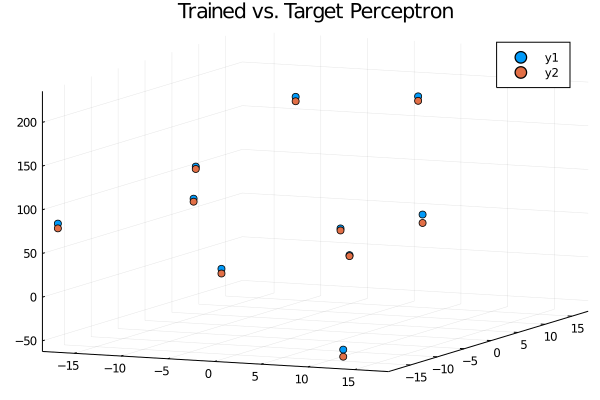

In [91]:
# Scatter plot of each
x = generate_data(10, X_RANGE, 10);
println(size(x))

println("Number of iterations: ", iters)
println("Loss: ", losses[end])
println("WITH simultaneous perceptron/policy training")
Plots.scatter(x[2,:], x[3,:], predict_linear(percep, x))
Plots.scatter!(x[2,:], x[3,:], predict_linear(targ, x))
Plots.title!("Trained vs. Target Perceptron")

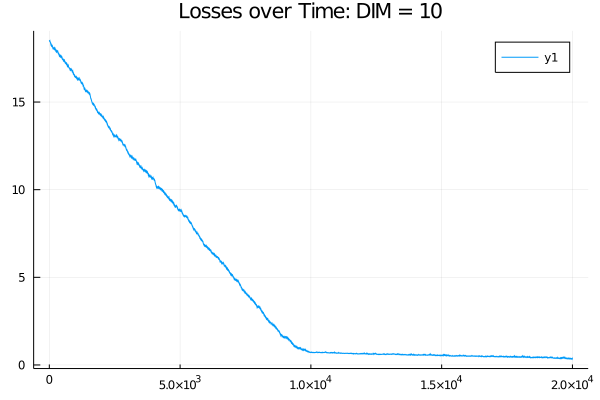

In [92]:
Plots.plot(losses)
Plots.title!("Losses over Time: DIM = 10")

In [93]:
# cache_02("../results/final/linear_10_applied.json"; losses=losses, target_perceptron=targ, generated_perceptron=percep,
#             policy=pol, datapoints=x, train_policy=false, alpha=α, epsilon=ϵ, gamma=γ, dim=dim, explore_prob=explore)

Caching successful.


## Part II: Logistic Regression Classifier

In [24]:
function logistic_experiment(dim::Int64, target::perceptron, iters::Int64, explore_prob::Float64, train_policy::Bool, pol::Any)
    num_iterations = iters;
    exploration_probability = explore_prob;
    percep = generate_perceptron(dim);
    x = generate_data(dim, X_RANGE, N);
    
    if pol == false || typeof(pol) != policy
        pol = new_policy();
        train_policy = true;
    end
    
    actions = zeros(dim, N_HIST).+2 # For DIM synapses we store their actions.
                                 # Starting with N_HIST actions set to 0.
    rewards = zeros(N_HIST).+2 # Rewards history is instantiated with N_HIST zeros.
    losses = zeros(N_HIST).+loss_logistic(percep, target, x)
 

    for i = 1:num_iterations
        actions = [actions zeros(dim)]
        append!(rewards, 0)

        # Iterating through each synapse and taking an action (inc/dec/same).
        for j = 1:dim
            addr = [actions[j, end-N_HIST:end-1]; rewards[end-N_HIST:end-1]]
            addr = convert(Array{Int64,1}, addr)
            
            a = 0; # Action taken by agent
            if rand() < exploration_probability 
                a = rand([1, 2, 3]); # Chose a random move
            else
    #             println("ACCESSING")
                a = argmax(pol.Q[:,addr...]); # Choose the "optimal" move given the 
                                              # Past actions and rewards
            end

            # We have now chosen our action.
            actions[j,end] = a;

            # Taking the action
            percep.w[j] += (a-2)*ϵ;
        end
        # Calculating reward for this iteration through all synapses.
        new_loss = loss_logistic(percep, target, x);
        R = 0;
        if(new_loss < losses[end])
            R = 3;
        else
            R = 1;
        end
    #     println("Old loss: ", losses[end])
#         println("New loss: ", new_loss)
    #     println("Reward: ", R)

        rewards[end] = R;
        append!(losses, new_loss)

        # Applying update rule for Q values on each synapse
        if train_policy
            for j = 1:dim
                addr_old = [actions[j, end-N_HIST:end-1]; rewards[end-N_HIST:end-1]]
                addr_new = [actions[j, end-N_HIST+1:end]; rewards[end-N_HIST+1:end]]

                addr_old = convert(Array{Int64,1}, addr_old)
                addr_new = convert(Array{Int64,1}, addr_new)

                max_future_term = γ*maximum(pol.Q[:,addr_new...]); 

                cur_term = pol.Q[ convert(Int64,actions[j,end]) , addr_old...];

                pol.Q[ convert(Int64,actions[j,end]) , addr_old...] = cur_term + α*( (R-2) + max_future_term - cur_term); 
            end
        else
#             println("NOT UPDATING POLICY!!");
        end
    end
    
    # Returning all actions taken, all rewards, all losses
    # And the final perceptron and the final perceptron learning policy.
    return actions, rewards, losses, percep, pol
end

logistic_experiment (generic function with 1 method)

In [25]:
dim = 3
targ = generate_perceptron(dim)
iters = 10000
train_policy = true
pol = false
explore = 0.5

actions, rewards, losses, percep, pol = 
    logistic_experiment(
        dim, 
        targ, 
        iters, 
        explore, 
        train_policy,
        pol 
    );


In [26]:
targ

perceptron([0.40935089286499693, -9.244206136444086, -2.010032767591179])

In [27]:
percep

perceptron([-19.615940581189736, -18.934608789948854, -5.072165671596547])

(3, 100)
Number of iterations: 10000
Loss: 0.010002939495519178
WITH simultaneous perceptron/policy training


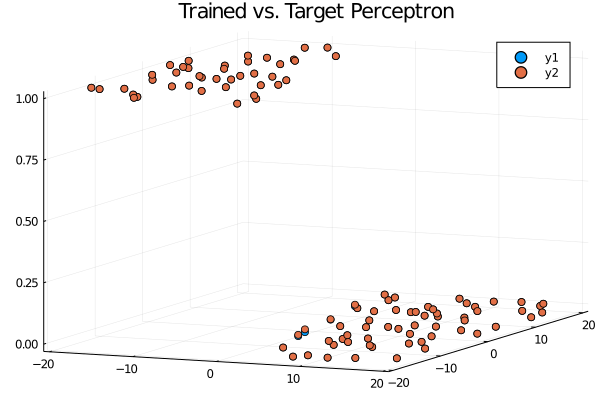

In [30]:
# Scatter plot of each
x = generate_data(dim, X_RANGE, 100);
println(size(x))

println("Number of iterations: ", iters)
println("Loss: ", losses[end])
println("WITH simultaneous perceptron/policy training")
Plots.scatter(x[2,:], x[3,:], predict_logistic(percep, x))
Plots.scatter!(x[2,:], x[3,:], predict_logistic(targ, x))
Plots.title!("Trained vs. Target Perceptron")

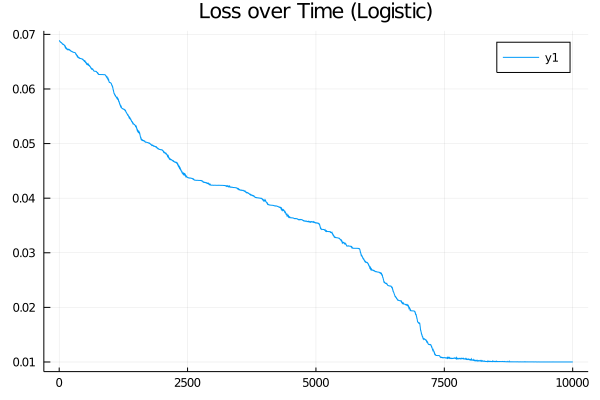

In [31]:
Plots.plot(losses)
Plots.title!("Loss over Time (Logistic)")

### Caching Adaptive Policy Logistic 2D

In [32]:
# cache_02("../results/final/logistic_2_adaptive.json"; losses=losses, target_perceptron=targ, generated_perceptron=percep,
#             policy=pol, datapoints=x, train_policy=true, alpha=α, epsilon=ϵ, gamma=γ, dim=dim, explore_prob=explore)

Caching successful.


### Logistic Regression: Re-Applying Learned Policy

In [48]:
dim = 3
targ = generate_perceptron(dim)
iters = 20000
train_policy = false
explore = 0.5

actions, rewards, losses, percep, pol = 
    logistic_experiment(
        dim, 
        targ, 
        iters, 
        explore, 
        train_policy,
        pol 
    );

In [49]:
targ

perceptron([-6.365497387845616, 6.19057290411658, -0.8936345843190852])

In [50]:
percep

perceptron([-10.338936890077756, 10.956435964000033, -1.5043016763717847])

(3, 100)
Number of iterations: 20000
Loss: 0.00039906192086275127
WITHOUT simultaneous perceptron/policy training


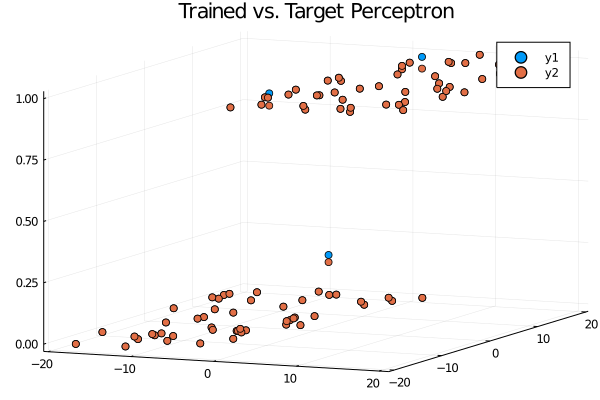

In [55]:
# Scatter plot of each
x = generate_data(dim, X_RANGE, 100);
println(size(x))

println("Number of iterations: ", iters)
println("Loss: ", losses[end])
println("WITHOUT simultaneous perceptron/policy training")
Plots.scatter(x[2,:], x[3,:], predict_logistic(percep, x))
Plots.scatter!(x[2,:], x[3,:], predict_logistic(targ, x))
Plots.title!("Trained vs. Target Perceptron")

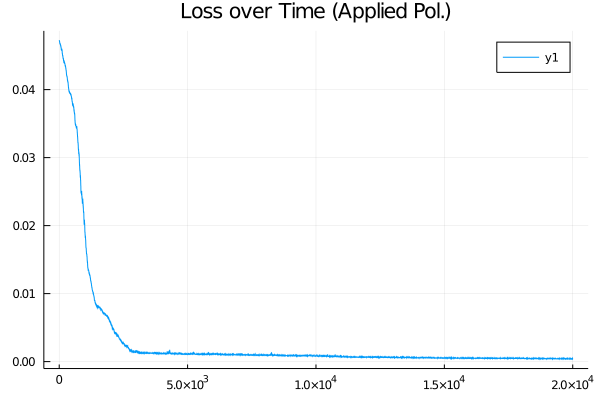

In [56]:
Plots.plot(losses)
Plots.title!("Loss over Time (Applied Pol.)")

(3, 100)
Number of iterations: 20000
Loss: 0.00039906192086275127


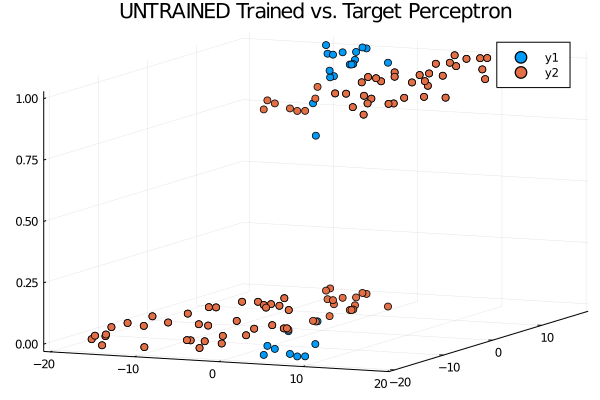

In [57]:
# Scatter plot of each
percep2 = generate_perceptron(dim)

x = generate_data(dim, X_RANGE, 100);
println(size(x))

println("Number of iterations: ", iters)
println("Loss: ", losses[end])
# println("WITHOUT simultaneous perceptron/policy training")
Plots.scatter(x[2,:], x[3,:], predict_logistic(percep2, x))
Plots.scatter!(x[2,:], x[3,:], predict_logistic(targ, x))
Plots.title!("UNTRAINED Trained vs. Target Perceptron")

### Caching Static 2D Logistic Regression

In [58]:
# cache_02("../results/final/logistic_2_applied.json"; losses=losses, target_perceptron=targ, generated_perceptron=percep,
#             policy=pol, datapoints=x, train_policy=false, alpha=α, epsilon=ϵ, gamma=γ, dim=dim, explore_prob=explore)

Caching successful.
